# Extracting sources

* Extracting sources from a fits file (SExtractor via sewpy)

In [79]:
import os , glob
import matplotlib.pyplot as plt
import sewpy
import math
import random
import numpy as np

from scipy.stats import sigmaclip
from astropy.io import fits

## Constants
BEAMARCSEC= 3600.

## Functions

* In  ubuntu you can use: "sudo apt install sextractor" to install sextractor
* In runsextractor, set the path for the binary of SExtractor ($>  which sextractor)

In [80]:
def runsextractor(image_file, wdir="./", detect_thresh=3.5, analysis_thresh=3.0):
    params = ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 
              'THRESHOLD', 'FLUX_MAX', 'XMAX_IMAGE', 'YMAX_IMAGE', 'XPEAK_IMAGE', 'YPEAK_IMAGE', 'ALPHAPEAK_J2000', 
              'DELTAPEAK_J2000', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']

    convfile= "/home/stephane/soft/sextractor/config/gauss_5.0_9x9.conv"
    # convfile= "/home/stephane/soft/sextractor/config/default.conv"
    
    config = {"DETECT_THRESH":detect_thresh, "ANALYSIS_THRESH":analysis_thresh, "FILTER_NAME":convfile}

    sew = sewpy.SEW(workdir=wdir, sexpath="/usr/bin/sextractor",params=params, config=config)

    out = sew(image_file)
    data = out["table"]
    
    ra, dec, flux, label = data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_MAX'], data['NUMBER'].astype('int')
    
    return ra, dec, flux, label


## get some parameters from the fits.
def getInfoFits(fitsimage):
    hdulist = fits.open(fitsimage)
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    bmin = float(hdr['BMIN']) * BEAMARCSEC
    bmaj = float(hdr['BMAJ']) * BEAMARCSEC
    ar = math.sqrt(bmin*bmaj)
    lonpole = float(hdr['CRVAL1'])
    latpole = float(hdr['CRVAL2'])
    
    freq = float(hdr['RESTFRQ']) / 1e9     ### frequency in GHz
    dx = abs(float(hdr['CDELT1'])) * BEAMARCSEC ## dx in arcsec
    
    return(freq)


## RMS estimation
def getRMSfits(fitsimage , nsample=40 , size= 20):
    
    random.seed()
    
    hdulist = fits.open(fitsimage)
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    
    data = hdulist[0].data
    
    rms = []
    for i in range(nsample):
        ix = random.randint(size,int(nx/2)-size)
        iy = random.randint(size,int(ny/2)-size)
        fx = random.random()
        fy = random.random()
        
        if fx < 0.5:
            ixcenter = ix
        else:
            ixcenter = nx - ix
            
        if fy < 0.5:
            iycenter = iy
        else:
            iycenter = ny - iy
            
        datrms = data[0, 0, ixcenter-size:ixcenter+size, iycenter-size:iycenter+size]
        rms.append(np.std(datrms))
        
    
    c, low, upp = sigmaclip(rms , 3.0 , 3.0)

    rmsestimated = np.median(c)    
    return(rmsestimated)   

## estimatng the best RMS noise for all fits file in a directory
def getBestRMS(direc, ext):
    files = glob.glob("%s/%s"%(direc,ext))
    
    bestrms= 1e9
    bestfile= ""
    for f in files:
        rms=  getRMSfits("%s/%s"%(direc,f))*1e3     ### RMS noise in mJy
        if rms < bestrms:
            bestrms = rms
            bestfile= f
            
    return(bestfile, bestrms)
        

## Main

* Extract the sources for each band
* The SIGMA value for the detection can be set. As a default it is set to 3.5.
* The flux indicated is in Jy/b
* The frequency (GHz) of each band is obtained by getInfoFits(band) where band is the fits file
* Note that SExtractor estimates various flux (different methods).
* In case of several images we estimate the best rms noise.

**In the example below we take the source J0811-4929**

In [81]:
## Directories
wdir =      "/home/stephane/Science/RadioGalaxy/ALMA/DeepField/analysis/c"
sourcedir= "/home/stephane/Science/RadioGalaxy/ALMA/DeepField/bosscha/J0811-4929"

## detection sigma
SIGMA= 3.0

## BAND 3
print("## Band 3")
os.chdir("%s/Band 3"%(sourcedir))
bestfile ,rms = getBestRMS("./", "*cont4.image.fits")
print("## Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
band3 = "uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits"
ra3, dec3 , flux3 , label3 = runsextractor(band3,detect_thresh=SIGMA)
freq3= getInfoFits(band3)

print("## Freq: %3.3f GHz"%(freq3))
print(flux3)


## BAND 4
os.chdir("%s/Band 4"%(sourcedir))
band4 = "uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits"
ra4, dec4 , flux4 , label4 = runsextractor(band4,detect_thresh=SIGMA)
freq4= getInfoFits(band4)
print("\n## Band 4")
print("## Freq: %3.3f GHz"%(freq4))
print(flux4)


## BAND 6
print("\n## Band 6")
os.chdir("%s/Band 6"%(sourcedir))
bestfile ,rms = getBestRMS("./", "*cont4.image.fits")
print("## Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
band6 = "uid___A002_Xb1e6b5_X1b44.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits"
band6 = "uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits"
ra6, dec6 , flux6 , label6 = runsextractor(band6,detect_thresh=SIGMA)
freq6= getInfoFits(band6)

print("## Freq: %3.3f GHz"%(freq6))
print(flux6)


## BAND 7
os.chdir("%s/Band 7"%(sourcedir))
band7 = "uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits"
ra7, dec7 , flux7 , label7 = runsextractor(band7,detect_thresh=SIGMA)
freq7= getInfoFits(band7)
print("\n## Band 7")
print("## Freq: %3.3f GHz"%(freq7))
print(flux7)


## BAND 8
os.chdir("%s/Band 8"%(sourcedir))
band8 = "uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits"
ra8, dec8 , flux8 , label8 = runsextractor(band8,detect_thresh=SIGMA)
freq8= getInfoFits(band8)
print("\n## Band 8")
print("## Freq: %3.3f GHz"%(freq8))
print(flux8)

Output catalog ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


## Band 3
## Best rms noise for file: ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.076 mJy)
## Freq: 90.500 GHz
 FLUX_MAX
    ct   
---------
0.3540781


Output catalog ./uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it



## Band 4
## Freq: 138.000 GHz
FLUX_MAX
   ct   
--------
0.272246

## Band 6
## Best rms noise for file: ./uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.046 mJy)


Output catalog ./uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


## Freq: 232.500 GHz
  FLUX_MAX  
     ct     
------------
0.0002086769
   0.1680943
0.0002714049

## Band 7
## Freq: 336.500 GHz
 FLUX_MAX
    ct   
---------
0.1399343

## Band 8
## Freq: 492.161 GHz
 FLUX_MAX
    ct   
---------
0.1259729


## Plots and first analysis



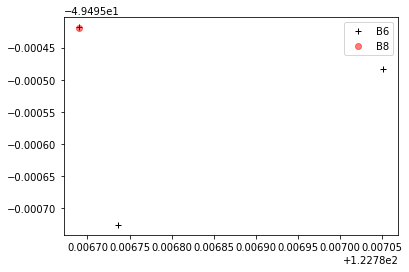

In [83]:

plt.plot(ra6,dec6,"k+", label="B6")
plt.plot(ra8,dec8,"ro", alpha=0.5, label="B8")
plt.legend()
plt.show()